# Setup

In [20]:
try:
    import google.colab
    !pip install diffusers==0.30.0 transformers accelerate scipy omegaconf dotenv loguru
except:
    pass

In [21]:
import os
import torch
import urllib.request

from transformers import pipeline
from diffusers import StableDiffusionPipeline
from pathlib import Path

In [22]:
root_dir = Path(os.getcwd()).parent
try:
    import google.colab
    !git clone https://github.com/tweks/sae-sd.git
    root_dir = Path(os.path.join(os.getcwd(), 'sae-sd'))
except:
    pass

In [23]:
model_url = 'https://github.com/tweks/sae-sd/releases/download/model-v0.0.1/12288_768_TopKReLU_64_False_False_0.0_CC3M_15_train_target_223758458_768.pt'
model_path = root_dir/'model'/'data'/os.path.basename(model_url)
if not os.path.exists(model_path):
    urllib.request.urlretrieve(model_url, model_path)

In [24]:
pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype= torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
clip = pipeline(
   task="zero-shot-image-classification",
   model="openai/clip-vit-base-patch32",
   torch_dtype=torch.float32,
   device=device,
)

Device set to use cpu


# Standard SD

In [26]:
prompt = "a photo of an astronaut riding a horse on mars"

In [27]:
prompt_embed = pipe.encode_prompt(prompt, device=device, num_images_per_prompt=1, do_classifier_free_guidance=True)[0]
prompt_embed.shape

torch.Size([1, 77, 768])

  0%|          | 0/50 [00:00<?, ?it/s]

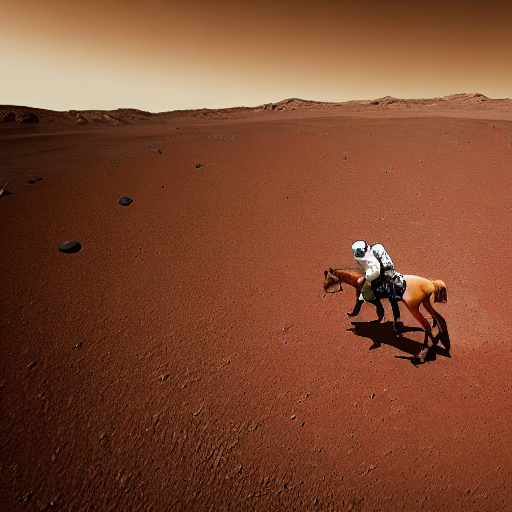

In [28]:
generator = torch.Generator(device).manual_seed(seed)
original_image = pipe(prompt_embeds=prompt_embed, generator=generator).images[0]
original_image 

# Modified SD

In [29]:
import sys
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
import json
import numpy as np
from model.models import load_model

In [30]:
model, dataset_normalize, dataset_target_norm, dataset_mean = load_model(str(root_dir/"model/data/12288_768_TopKReLU_64_False_False_0.0_CC3M_15_train_target_223758458_768.pt"))
model.to(device)
model.eval()
model, dataset_normalize, dataset_target_norm, dataset_mean.shape

(Autoencoder(
   (activation): TopK(
     k=64, act_fn=ReLU(), use_abs=False
     (act_fn): ReLU()
   )
   (latent_soft_cap): Identity()
 ),
 False,
 27.712812921102035,
 torch.Size([768]))

In [ ]:
ds_info = json.load(open(root_dir/"model/data/CC3M_15_train_target_sds_train_dataset_metadata.json"))
ds_info.keys()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tweks/Developer/sae-sd/sae-sd/model/data/CC3M_15_train_target_sds_train_dataset_metadata.json'

In [32]:
dataset_scaling_factor = ds_info["scaling_factor"]
lenses = None
seq_id = 0
seq_len = 0
dataset_scaling_factor

1.0926562485876634

In [33]:
def process_data(data: np.ndarray | torch.Tensor, idx: int | None=None) -> torch.Tensor:
    """Process data into the correct format."""
    X = data.to(torch.float32)
    X.sub_(dataset_mean)
    X.mul_(dataset_scaling_factor)

    if lenses is not None and idx is not None:
        current_seq_id = idx % seq_len
        if current_seq_id != seq_id:
            lens = lenses[current_seq_id]
            X = lens(X)

    return X

def invert_preprocess(data: torch.Tensor, idx: int | None=None) -> torch.Tensor:
    """Inverse process data."""
    if lenses is not None and idx is not None:
        current_seq_id = idx % seq_len
        if current_seq_id != seq_id:
            lens = lenses[current_seq_id]
            X = lens.invert(data)
        else:
            X = data
    else:
        X = data

    X.div_(dataset_scaling_factor)
    X.add_(dataset_mean)

    return X

In [34]:
prompt_embed_to_sae = prompt_embed.squeeze(0)
prompt_embed_to_sae.shape

torch.Size([77, 768])

In [35]:
prompt_embed_to_sae_pre = process_data(prompt_embed_to_sae)
prompt_embed_to_sae_post = invert_preprocess(prompt_embed_to_sae_pre)
prompt_embed_to_sae_post.shape, prompt_embed_to_sae_post.shape, torch.allclose(prompt_embed_to_sae, prompt_embed_to_sae_post, atol=1e-5)

(torch.Size([77, 768]), torch.Size([77, 768]), True)

In [ ]:
concepts = []
with open(root_dir/"sae-sd/model/data/clip_disect_20k.txt") as f:
    concepts = [line.strip() for line in f.readlines()]

In [38]:
idx = concepts.index("horse")
a = pipe.encode_prompt(concepts[idx], device=device, num_images_per_prompt=1, do_classifier_free_guidance=True)[0]
a = a.squeeze(0)
a_proc = process_data(a)
with torch.no_grad():
    _, latents, _ = model.encode(a_proc)
for latent in latents[1:10]:
    nonzero_values = latent[latent != 0]
    nonzero_indices = latent.nonzero().squeeze()
    sorted_values, sort_indices = torch.sort(nonzero_values, descending=True)
    sorted_indices = nonzero_indices[sort_indices]
    print("Sorted values:", {v.item():f"{i.item():.4f}" for v,i in zip(sorted_indices, sorted_values)})
print("----------------------------------")
        

Sorted values: {1825: '10.6824', 3678: '9.5770', 12214: '7.4469', 3232: '6.4037', 5722: '5.8637', 4136: '5.6067', 9515: '4.9997', 8542: '3.9340', 5482: '3.6375', 4685: '3.4531', 7513: '3.1126', 4112: '2.6551', 11265: '2.3089', 24: '2.2262', 3673: '2.2154', 6688: '2.1826', 2246: '2.0771', 3446: '2.0756', 2148: '2.0297', 7928: '2.0287', 9410: '1.9336', 9139: '1.8889', 11446: '1.8828', 9826: '1.8629', 3204: '1.8561', 7210: '1.8114', 2064: '1.8011', 12090: '1.7187', 11964: '1.6889', 12210: '1.6810', 10604: '1.6625', 2336: '1.6535', 325: '1.6473', 187: '1.6316', 11367: '1.6102', 8270: '1.5860', 4198: '1.5822', 7945: '1.5719', 4963: '1.5544', 1675: '1.5538', 498: '1.5496', 10408: '1.5469', 9478: '1.5317', 5956: '1.5235', 685: '1.4997', 8050: '1.4897', 11870: '1.4795', 10866: '1.4794', 4089: '1.4776', 5444: '1.4699', 9590: '1.4696', 3685: '1.4667', 326: '1.4418', 5267: '1.4201', 534: '1.4102', 3653: '1.3927', 3791: '1.3783', 9563: '1.3588', 10982: '1.3261', 6467: '1.3158', 10690: '1.2857', 62

Before modification tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9827, 1.0451, 1.1550, 4.6447,
        6.2782, 5.1288, 7.5422, 7.4933, 7.5121, 7.5330, 7.5685, 7.6229, 7.6558,
        7.6924, 7.7145, 7.7285, 7.7588, 7.7804, 7.8028, 7.8244, 7.8349, 7.8573,
        7.8782, 7.8963, 7.9176, 7.9306, 7.9423, 7.9614, 7.9791, 7.9971, 8.0095,
        8.0133, 8.0276, 8.0338, 8.0363, 8.0470, 8.0534, 8.0637, 8.0673, 8.0732,
        8.0771, 8.0873, 8.0916, 8.0843, 8.0838, 8.0734, 8.0813, 8.0803, 8.0908,
        8.0964, 8.0925, 8.0950, 8.0851, 8.0924, 8.0921, 8.0884, 8.1026, 8.0907,
        8.0961, 8.0970, 8.0953, 8.1031, 8.0934, 8.0991, 8.1018, 8.0969, 8.1047,
        8.1000, 8.1135, 8.1084, 8.1025, 8.0909])


  0%|          | 0/50 [00:00<?, ?it/s]

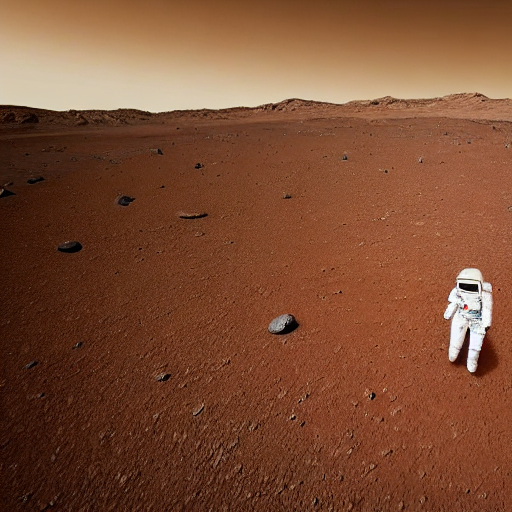

In [39]:
with torch.no_grad():
    _, sae_latents, info = model.encode(prompt_embed_to_sae_pre)
    prompt_embed_to_sae_reconstructed = model.decode(sae_latents, info)
    print("Before modification", sae_latents[:,5722])
    sae_latents[:,5722] = 0
    prompt_embed_to_sae_reconstructed_modified = model.decode(sae_latents, info)

prompt_embed_to_sae_reconstructed_post = invert_preprocess(prompt_embed_to_sae_reconstructed)
diff = prompt_embed_to_sae - prompt_embed_to_sae_reconstructed_post
prompt_embed_to_sae_reconstructed_post_modified = invert_preprocess(prompt_embed_to_sae_reconstructed_modified)

generator = torch.Generator(device).manual_seed(seed)
image_from_embed = pipe(prompt_embeds=(prompt_embed_to_sae_reconstructed_post_modified + diff).unsqueeze(0), generator=generator).images[0]
image_from_embed

In [40]:
original_image
labels = ["an image containing a horse", "an image without a horse"]
original_predictions = clip(original_image, candidate_labels=labels)
modified_predictions = clip(image_from_embed, candidate_labels=labels)
print("Original image predictions:", original_predictions)
print("Modified image predictions:", modified_predictions)

Original image predictions: [{'score': 0.6134726405143738, 'label': 'an image containing a horse'}, {'score': 0.38652732968330383, 'label': 'an image without a horse'}]
Modified image predictions: [{'score': 0.9062981009483337, 'label': 'an image without a horse'}, {'score': 0.09370198100805283, 'label': 'an image containing a horse'}]


# SD comparison

In [ ]:
def generate_image(prompt):
    prompt_embed = pipe.encode_prompt(prompt, device=device, num_images_per_prompt=1, do_classifier_free_guidance=True)[0]
    generator = torch.Generator(device).manual_seed(seed)
    return pipe(prompt_embeds=prompt_embed, generator=generator).images[0]

In [ ]:
generate_image('a photo of an astronaut on mars')

In [ ]:
generate_image('a photo of an astronaut not riding a horse on mars')

In [ ]:
generate_image('a photo of an astronaut riding a on mars')

# Green

In [41]:
idx = concepts.index("green")
a = pipe.encode_prompt(concepts[idx], device=device, num_images_per_prompt=1, do_classifier_free_guidance=True)[0]
a = a.squeeze(0)
a_proc = process_data(a)
with torch.no_grad():
    _, latents, _ = model.encode(a_proc)
for latent in latents[1:10]:
    nonzero_values = latent[latent != 0]
    nonzero_indices = latent.nonzero().squeeze()
    sorted_values, sort_indices = torch.sort(nonzero_values, descending=True)
    sorted_indices = nonzero_indices[sort_indices]
    print("Sorted values:", {v.item():f"{i.item():.4f}" for v,i in zip(sorted_indices, sorted_values)})
print("----------------------------------")
        

Sorted values: {8170: '13.0583', 2649: '10.0814', 3678: '8.5498', 12214: '8.0398', 8542: '5.2337', 9515: '4.8389', 11889: '4.7554', 2148: '4.4864', 7283: '4.1035', 5247: '3.9300', 3232: '3.3864', 8892: '3.2351', 10254: '2.8712', 11168: '2.6567', 781: '2.6539', 6322: '2.5972', 6759: '2.5907', 759: '2.4796', 3556: '2.3791', 6688: '2.2732', 9139: '2.2705', 6906: '2.1567', 12098: '2.1140', 957: '2.0994', 3145: '2.0676', 2862: '1.9878', 4092: '1.8730', 947: '1.8711', 685: '1.8664', 1642: '1.8347', 2906: '1.8309', 6487: '1.8180', 12086: '1.7735', 4448: '1.7150', 3204: '1.6196', 10078: '1.5892', 2072: '1.5690', 2172: '1.5686', 11940: '1.5395', 9694: '1.5222', 5640: '1.4828', 7216: '1.4542', 5570: '1.4315', 3975: '1.4250', 7022: '1.4144', 6110: '1.4013', 11804: '1.3841', 5551: '1.3677', 6746: '1.3479', 1705: '1.3178', 9614: '1.3170', 737: '1.3098', 3582: '1.3090', 1253: '1.3035', 7822: '1.2933', 4755: '1.2790', 8090: '1.2729', 2765: '1.2580', 10510: '1.2537', 12254: '1.2380', 8987: '1.2355', 3

Before modification tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7961,
        0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


  0%|          | 0/50 [00:00<?, ?it/s]

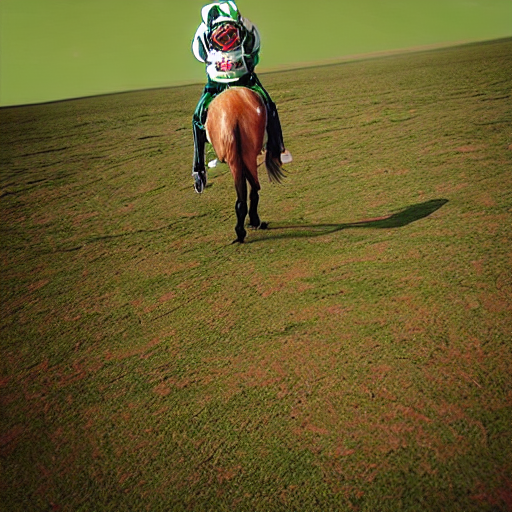

In [42]:
with torch.no_grad():
    _, sae_latents, info = model.encode(prompt_embed_to_sae_pre)
    prompt_embed_to_sae_reconstructed = model.decode(sae_latents, info)
    print("Before modification", sae_latents[:,2649])
    sae_latents[:,2649] = 9
    prompt_embed_to_sae_reconstructed_modified = model.decode(sae_latents, info)

prompt_embed_to_sae_reconstructed_post = invert_preprocess(prompt_embed_to_sae_reconstructed)
diff = prompt_embed_to_sae - prompt_embed_to_sae_reconstructed_post
prompt_embed_to_sae_reconstructed_post_modified = invert_preprocess(prompt_embed_to_sae_reconstructed_modified)

generator = torch.Generator(device).manual_seed(seed)
image_from_embed = pipe(prompt_embeds=(prompt_embed_to_sae_reconstructed_post_modified + diff).unsqueeze(0), generator=generator).images[0]
image_from_embed

In [43]:
original_image
labels = ["an image containing green", "an image without green"]
original_predictions = clip(original_image, candidate_labels=labels)
modified_predictions = clip(image_from_embed, candidate_labels=labels)
print("Original image predictions:", original_predictions)
print("Modified image predictions:", modified_predictions)

Original image predictions: [{'score': 0.800854504108429, 'label': 'an image without green'}, {'score': 0.19914551079273224, 'label': 'an image containing green'}]
Modified image predictions: [{'score': 0.8380439877510071, 'label': 'an image containing green'}, {'score': 0.1619560718536377, 'label': 'an image without green'}]


SAE ids which are not usable when interpeting the model

11114 padding connected

3678 beginning of the sentence